In [1]:
####### this code is for ATOC 7500 project 3 part I
### GENERAL SETUP
%matplotlib inline  
# this enables plotting within notebook

#import modules
import numpy as np
import matplotlib.pyplot as plt
import xarray
import numpy as np   # basic math library,type np.$STUFF
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import cartopy.crs as ccrs
import datetime
from netCDF4 import Dataset
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 
#import netcdf4 as nc

In [2]:
#### Read in and check Data
nc_fid=xarray.open_dataset('TS.nc')
lat = nc_fid.variables['lat'][:]  # extract/copy the data
lon = nc_fid.variables['lon'][:]
time = nc_fid.variables['time'][:]
TS = nc_fid.variables['TS'][:,:,:]
print('number of lat:', np.shape(lat))
print('number of lon:', np.shape(lon))
print('number of time:', np.shape(time))
print('number of TS:', np.shape(TS))
print(nc_fid['time'])

number of lat: (192,)
number of lon: (288,)
number of time: (240,)
number of TS: (240, 192, 288)
<xarray.DataArray 'time' (time: 240)>
array([cftime.DatetimeNoLeap(2081, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2081, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2081, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2081-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds


In [3]:
#### Step 1. Prepare data
## 1. cut data to the area of North America
minlat=25
maxlat=55
minlon=220
maxlon=300
TS_data_ori=nc_fid['TS'].sel(lat=slice(minlat,maxlat)).sel(lon=slice(minlon,maxlon))
lon=nc_fid['lon'].sel(lon=slice(minlon,maxlon))
lat=nc_fid['lat'].sel(lat=slice(minlat,maxlat))
time=nc_fid['time']
print('size of TS:', np.shape(TS_data_ori))
print('size of lon:', len(lon))
print('size of lat:', len(lat))
temp_array=np.empty(len(time))
TS_time=np.empty(len(time))  ## change time into year.month for plot ticks
for tindex, t in enumerate (temp_array):
    TS_time[tindex]=(tindex+1)/12+2081

size of TS: (240, 31, 65)
size of lon: 65
size of lat: 31


In [4]:
#### Step 1. Prepare data
## 2. consine weight
TS_cosine=TS_data_ori*np.sqrt(np.cos(lat*np.pi/180))
## 3. get anomally
TS_anom=TS_data_ori-TS_data_ori.mean('time');
TS_cosine_anom=TS_cosine-TS_cosine.mean('time');

In [5]:
## 4. remove seasonal cycle
climo=TS_cosine_anom.groupby('time.month').mean('time')
TS_nocycle=TS_cosine_anom.groupby('time.month')-climo
print(np.shape(climo))

(12, 31, 65)


In [6]:
#### Step 1. Prepare data
## 5. standardize
TS_stand=(TS_nocycle-TS_nocycle.mean('time'))/(TS_nocycle.std('time'));
## 6. resize the data to 2D
a,b,c=np.shape(TS_stand.values)  ## have axis sizes for later (a, b, c)
TS_reshape=TS_stand.values.reshape(a,b*c);
TS_ori_reshape=TS_anom.values.reshape(a,b*c);
print(a,b,c)
print(np.shape(TS_reshape))
print(np.shape(TS_ori_reshape))

240 31 65
(240, 2015)
(240, 2015)


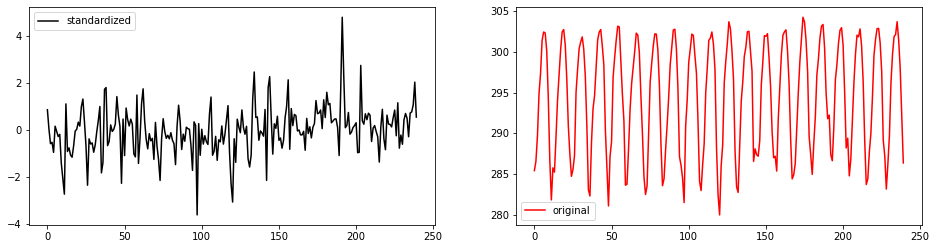

In [7]:
#plot the standardized and original time series for one location
f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0]);
plt.plot(TS_reshape[:,500],label='standardized',color='black');
plt.legend();
plt.subplot(gs[0,1]);
plt.plot(TS_data_ori.values.reshape(a,b*c)[:,500],label='original',color='red');
plt.legend();

In [8]:
#### Step 2. Calculate EOFs and PCs
## 1. using eigen analysis
# calculate covariance matrix
C = 1./np.size(TS_reshape,axis = 0)*np.dot(np.transpose(TS_reshape),TS_reshape) ## Barnes Chapter 3 Equation 7
print(np.shape(TS_reshape))
print(np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method
lam, E = LA.eig(C) ## Barnes Chapter 3 Equation 42

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

(240, 2015)
(2015, 2015)


In [9]:
## 2. using SVD
u,s,v=LA.svd(TS_reshape)  ## Barnes Chapter 3 Equation (65)

first 3 eigenvalues: 23 %, 19 %, 12 %
240
(240,)
lag1 autocorrelation from np.correlate: 0.553
[69.]


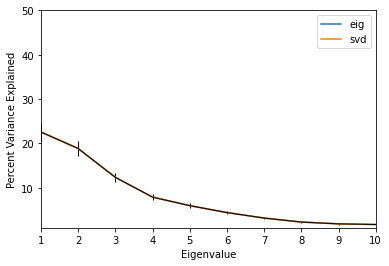

In [10]:
## 3. calculate PCs
# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))

print('first 3 eigenvalues:', round(pve[0]),'%,',round(pve[1]),'%,',round(pve[2]),'%')
f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,50])
plt.xlim([1,10])
plt.ylabel('Percent Variance Explained')
plt.xlabel('Eigenvalue')
plt.legend()

Nstar = np.size(TS_reshape,axis = 0) ## assume all data is independent (not a great assumption)
print(Nstar)
###  could for example - find the effective sample size using the average of all data
###  Caution: Use the data that went into the EOF analysis for this calculation, not the original data...
tseries=np.nanmean(np.nanmean(TS_stand,axis=2),axis=1)  
print(np.shape(tseries))
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
N=len(tseries)         ## calculate the length of the timeseries
lag=1
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean
alpha=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print('lag1 autocorrelation from np.correlate:',round(alpha[0],3))
### Calculate the effective sample size (Nstar) for this data
### To estimate the number of independent samples - Chapter 2 Barnes Eq. 88
Nstar=np.round((1-alpha)/(1+alpha)*N,0)
print(Nstar)
eb = pve*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black');

(2015,)
(240,)
(2015, 2015) (240,) (240, 240)
(31, 65)
(240,)


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


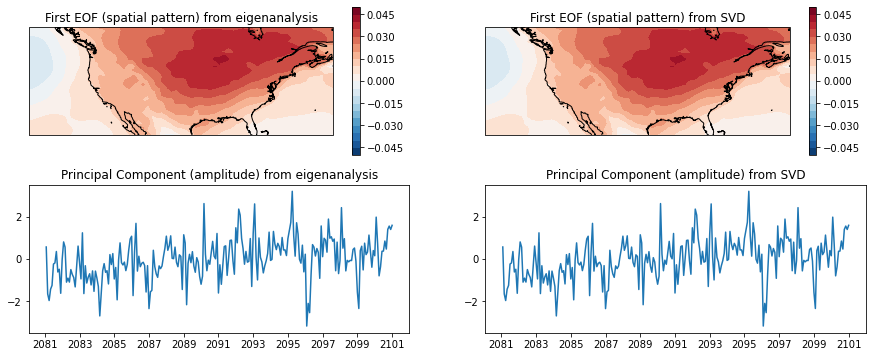

In [11]:
#### Step 3, Plot EOFs and PCs
## 1, first EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(np.shape(e1))

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(TS_reshape,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(np.shape(z1))

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e1_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(np.shape(z1_svd))

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('First EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(TS_time,z1)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=260))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e1_svd),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('First EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(TS_time,z1_svd)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from SVD');

(2015, 2015) (240,) (240, 240)
(31, 65)


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


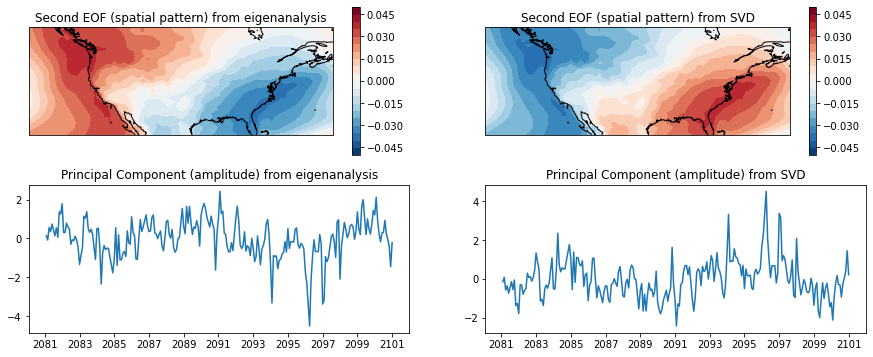

In [12]:
## 2, Second EOF
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e2 = E[:,eof_num-1]


# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z2 = np.dot(TS_reshape,e2)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z2 = (z2-np.mean(z2))/np.std(z2)  


# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e2_svd = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e2_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z2_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z2_svd = (z2_svd-np.mean(z2_svd))/np.std(z2_svd)  


### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
CS=ax.contourf(lon,lat,e2.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('Second EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(TS_time,z2)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=260))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e2_svd),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('Second EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(TS_time,z2_svd)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from SVD');

(2015, 2015) (240,) (240, 240)
(31, 65)


/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


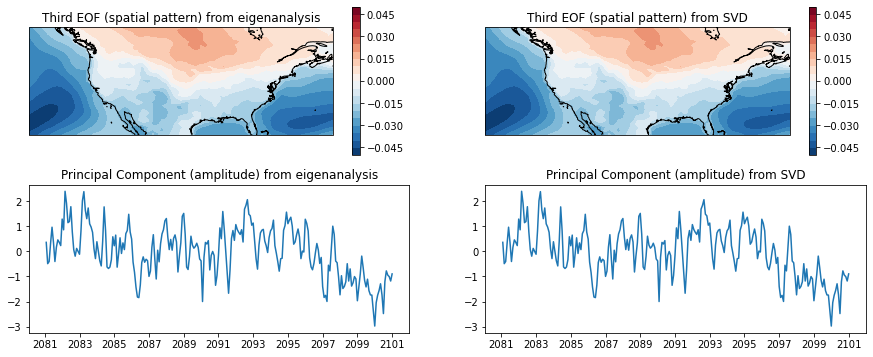

In [13]:
## 3, Third EOF
eof_num=3

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e3 = E[:,eof_num-1]


# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z3 = np.dot(TS_reshape,e3)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z3 = (z3-np.mean(z3))/np.std(z3)  


# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e3_svd = (v[eof_num-1,:]).reshape(b,c)
print(np.shape(e3_svd))

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z3_svd = u[:,eof_num-1]*(s[eof_num-1])
## standardize it
z3_svd = (z3_svd-np.mean(z3_svd))/np.std(z3_svd)  


### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
CS=ax.contourf(lon,lat,e3.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('Third EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(TS_time,z3)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=260))
levels=levels+1e-14 
CS=ax.contourf(lon,lat,np.real(e3_svd),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('Third EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(TS_time,z3_svd)
plt.xticks(np.arange(2081, 2103, 2))
plt.title('Principal Component (amplitude) from SVD');

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


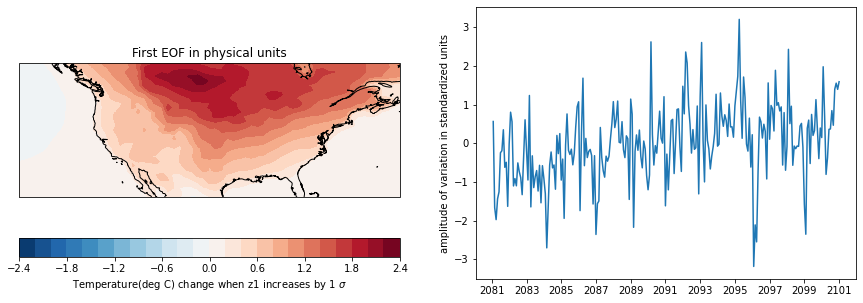

In [20]:
####### Step 4. Regress
# first EOF
d1 = (1./np.size(TS_ori_reshape,axis=0))*np.dot(np.transpose(z1),TS_ori_reshape)   ## Barnes Chapter 3 Equation (79)
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-2.4,2.6,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Temperature(deg C) change when z1 increases by 1 $\sigma$')
plt.title('First EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(TS_time,z1)
plt.xticks(np.arange(2081, 2103, 2))
plt.ylabel('amplitude of variation in standardized units');

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


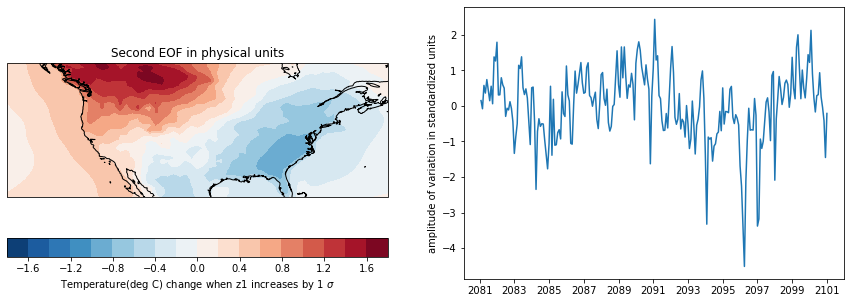

In [23]:
# second EOF
d2 = (1./np.size(TS_ori_reshape,axis=0))*np.dot(np.transpose(z2),TS_ori_reshape)   ## Barnes Chapter 3 Equation (79)
d2plot = d2.reshape(b,c)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-1.8,2.0,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d2plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Temperature(deg C) change when z1 increases by 1 $\sigma$')
plt.title('Second EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(TS_time,z2)
plt.xticks(np.arange(2081, 2103, 2))
plt.ylabel('amplitude of variation in standardized units');

/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/projects/chlv5900/software/anaconda/envs/mycustomenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


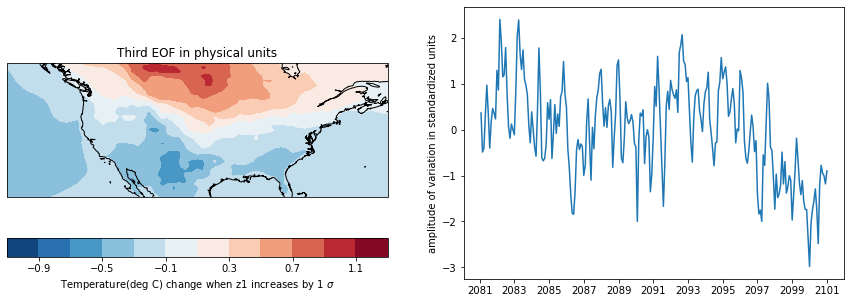

In [24]:
# Third EOF
d3 = (1./np.size(TS_ori_reshape,axis=0))*np.dot(np.transpose(z3),TS_ori_reshape)   ## Barnes Chapter 3 Equation (79)
d3plot = d3.reshape(b,c)  ### this is the reshaped eigenvector to plot


f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-1.1,1.3,0.2)
levels2=levels2+1e-14 
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=260))
CS=ax.contourf(lon,lat,d3plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('Temperature(deg C) change when z1 increases by 1 $\sigma$')
plt.title('Third EOF in physical units')
plt.subplot(gs[0,1])
plt.plot(TS_time,z3)
plt.xticks(np.arange(2081, 2103, 2))
plt.ylabel('amplitude of variation in standardized units');